In [1]:
''' Import Modules '''
import os
import sys
import warnings
import numpy as np 
import pandas as pd 
from pandas import set_option
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
        
if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
!pip install seaborn --upgrade

     |████████████████████████████████| 285 kB 893 kB/s 
     |████████████████████████████████| 283 kB 3.6 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import seaborn as sns
print(sns.__version__)

0.11.1


# 1. Introduction

## 1.1. <span style='color:#F1C40F'> Problem Definition </span>

- The goal of this problem is quite model centric; predict the target variable `SPL` (Sound Pressure Level) as accurately as possible, given a set of features (independent variables). 
- The data itself is quite interesting, so it's worth to explore it & understand something about fluid flow.
- Let's also see if we can pinpoint specific parts of the data to some noise sources (listed above). Although, this is quite a challenge, given we don't have visual data.

## 1.2. <span style='color:#F1C40F'> Sources of Airfoil Noise </span>

### <span style='color:#5D6D7E'>Relevant Noise Sources</span>

`Turbulent-Boundary-Layer-Trailing-Edge Noise (TBL-TE)`<br>
At high Reynolds number (based on chord length), turbulent boundary layers (TBL) develop over most of the airfoil. Noise is produced as this turbulence passes over the trailing edge (TE). <br>

`Laminar-Boundary-Layer-Vortex-Shedding Noise (LBL-VS)`<br>
At low Reynolds number, largely laminar boundary layer (LBL) develop, whose instability result in vortex shedding (VS) and associated noise from the TE. For non aoa=0, the flow can separate near the TE on the suction side of the airfoil to produce TE noise due to the shed turbulent vorticity. <br>

`Separation-Stall Noise`<br>
At very high aoa, the separated flow near the TE gives way to large-scale separation (deep stall), causing the airfoil to radiate low-frequency noise similar to that of a bluff body in flow. <br>
In the work of Wagner et al. (1996), it is indicated that mildly separated flow causes
sound radiation from the trailing edge, whereas deep stall causes radiation from the whole airfoil.

So what we might try to do is pay attention to the features `u_inf`,`l_chord` (which we have), as they are relevant to `Reynolds Number`. The other two (`density`,`viscosity`) we don't have we'll have to assume they are constant.

### <span style='color:#5D6D7E'>Less Relevant Noise Sources </span><br>

`Trailing-Edge-Bluntness-Vortex Shedding Noise` <br>
Another noise source is vortex shedding occuring in the small separated flow region aft of the blunt TE
Source is likely irrelavent as the TE is quoted to be 'very sharp' with a thickness of less than 0.05mm <br>

`Tip Vortex Formation Noise` <br>
The last source considered here is due to the formation of the tip vortex, containing high turbulent flow, occuring near the tips of lighting wings. 

<b>Sources of Noise from Airfoil Self-Noise and Prediction, T.F.Brooks et al, 1989</b>

## 1.3. <span style='color:#F1C40F'> Experimental Description </span>
- The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. 
- The span of the airfoil and the observer position were the same in all of the experiments. Based on the origin of this dataset ([UCI Database](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)), it's not certain whether the dataset contains tripped or non tripped cases (which is critical to know)
- If you are interested in reading the full paper, you can find it by searching the paper idenification `NASA RP-1218`, it's best to manually extract the data from the paper & not utilise the `UCI Database`, nevertheless.

## 1.4. <span style='color:#F1C40F'> Brief Feature Description </span>

### <span style='color:#5D6D7E'><b>Independent Variables</b><br></span>
- <b>freq</b> : Frequency, in Hertz (Hz). <br>
- <b>aoa</b> : Angle of attack (degrees). <br>
- <b>l_chord</b> : Chord length (m). <br>
- <b>u_inf</b> : Free-stream velocity. <br>
- <b>l_sdisp</b> : Suction side displacement thickness.

### <span style='color:#5D6D7E'><b>Target Variable</b><br></span>
- <b>spl</b> : Sound Pressure Level.
    
***
Most Features most likely are quite straightforward with the exception for one; <b>relevant to l_sdisp</b>

- The suction side displacement thickness was determined using an expression derived from
boundary layer experimental data from Brooks(1989) 
- (Boundary Layer) displacement thickness is the imaginary increase in thicknes of the wall; due to the effect of growing boundary layer.
Scaled Sound Pressure Level (dB)

# 2. Dataset : Initial Impression
Early data inspection with pandas trio .info(),describe(),head(), just some very early observations.

In [4]:
file = '/kaggle/input/noises/airfoil_self_noise.dat'

# define shortform column names
columns = ['freq','aoa','l_chord','u_inf','l_sdisp','spl']
df = pd.read_csv(file,names=columns,header=0,delimiter='\t')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   freq     1502 non-null   int64  
 1   aoa      1502 non-null   float64
 2   l_chord  1502 non-null   float64
 3   u_inf    1502 non-null   float64
 4   l_sdisp  1502 non-null   float64
 5   spl      1502 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.5 KB


In [6]:
set_option('precision',2)
df.head(13).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
freq,1.00e+03,1.25e+03,1.60e+03,2.00e+03,2.50e+03,3.15e+03,4.00e+03,5.00e+03,6.30e+03,8.00e+03,1.00e+04,1.25e+04,1.60e+04
aoa,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
l_chord,3.05e-01,3.05e-01,3.05e-01,3.05e-01,3.05e-01,3.05e-01,3.05e-01,3.05e-01,3.05e-01,3.05e-01,3.05e-01,3.05e-01,3.05e-01
u_inf,7.13e+01,7.13e+01,7.13e+01,7.13e+01,7.13e+01,7.13e+01,7.13e+01,7.13e+01,7.13e+01,7.13e+01,7.13e+01,7.13e+01,7.13e+01
l_sdisp,2.66e-03,2.66e-03,2.66e-03,2.66e-03,2.66e-03,2.66e-03,2.66e-03,2.66e-03,2.66e-03,2.66e-03,2.66e-03,2.66e-03,2.66e-03
spl,1.25e+02,1.26e+02,1.28e+02,1.27e+02,1.26e+02,1.25e+02,1.23e+02,1.21e+02,1.20e+02,1.17e+02,1.15e+02,1.12e+02,1.09e+02


The dataset contains data ordered by <b>frequency</b> subgroups; here 1kHz - 16kHz

In [7]:
df.describe()

,freq,aoa,l_chord,u_inf,l_sdisp,spl
count,1502.00,1502.00,1502.00,1502.00,1.50e+03,1502.00
mean,2887.77,6.79,0.14,50.85,1.11e-02,124.84
std,3153.16,5.92,0.09,15.57,1.32e-02,6.90
min,200.00,0.00,0.03,31.70,4.01e-04,103.38
25%,800.00,2.00,0.05,39.60,2.54e-03,120.19
50%,1600.00,5.40,0.10,39.60,4.96e-03,125.72
75%,4000.00,9.90,0.23,71.30,1.58e-02,130.00
max,20000.00,22.20,0.30,71.30,5.84e-02,140.99


In [8]:
# Plot Correlation to Target Variable only
def corrMat(df,target='demand',figsize=(9,0.5),ret_id=False):
    
    corr_mat = df.corr().round(2);shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy() 
    
    if(ret_id is False):
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corr,vmin=-0.3,vmax=0.3,center=0, 
                     cmap='viridis',square=False,lw=2,annot=True,cbar=False)
        plt.title(f'Feature Correlation to {target}')
    
    if(ret_id):
        return corr

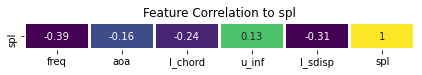

In [9]:
corrMat(df,'spl',figsize=(7,0.5)) # Baseline Dataframe feature correlation to Signal

# 3. Exploritory Data Analysis

In our problem, we don't have a lot of features to go by. Visual data would be very valuable to for noise identification. EDA for this problem likely going to quite a challenge given how complex and variant anything associated to turbulence is. 'The main data relation we'll keep referring to is `freq` vs `spl`, which represents the frequency domain noise spectrum.

## 3.1. <span style='color:#F1C40F'>EDA: PairGrids</span>
Let's look at some two feature relation plots in the form of PairGrids. They are quite loaded with information, so let's pay attention mainly at 1D histograms and `bivariate` relations for our target variable, `spl`

In [10]:
lst_vars = df.columns.to_list();lst_vars

['freq', 'aoa', 'l_chord', 'u_inf', 'l_sdisp', 'spl']

In [11]:
''' Draw a Bivariate Seaborn Pairgrid /w KDE density w/ '''
def snsPairGrid(df):

    sns.set(style='whitegrid')
    g = sns.PairGrid(df,diag_sharey=False,height=4)
    g.fig.set_size_inches(15,15)
    g.map_diag(sns.kdeplot, lw=2)
    g.map_lower(sns.scatterplot,s=25,edgecolor="k",linewidth=0.5,alpha=0.4)
    g.map_lower(sns.kdeplot,cmap='plasma',n_levels=6,alpha=0.5)
    plt.tight_layout()

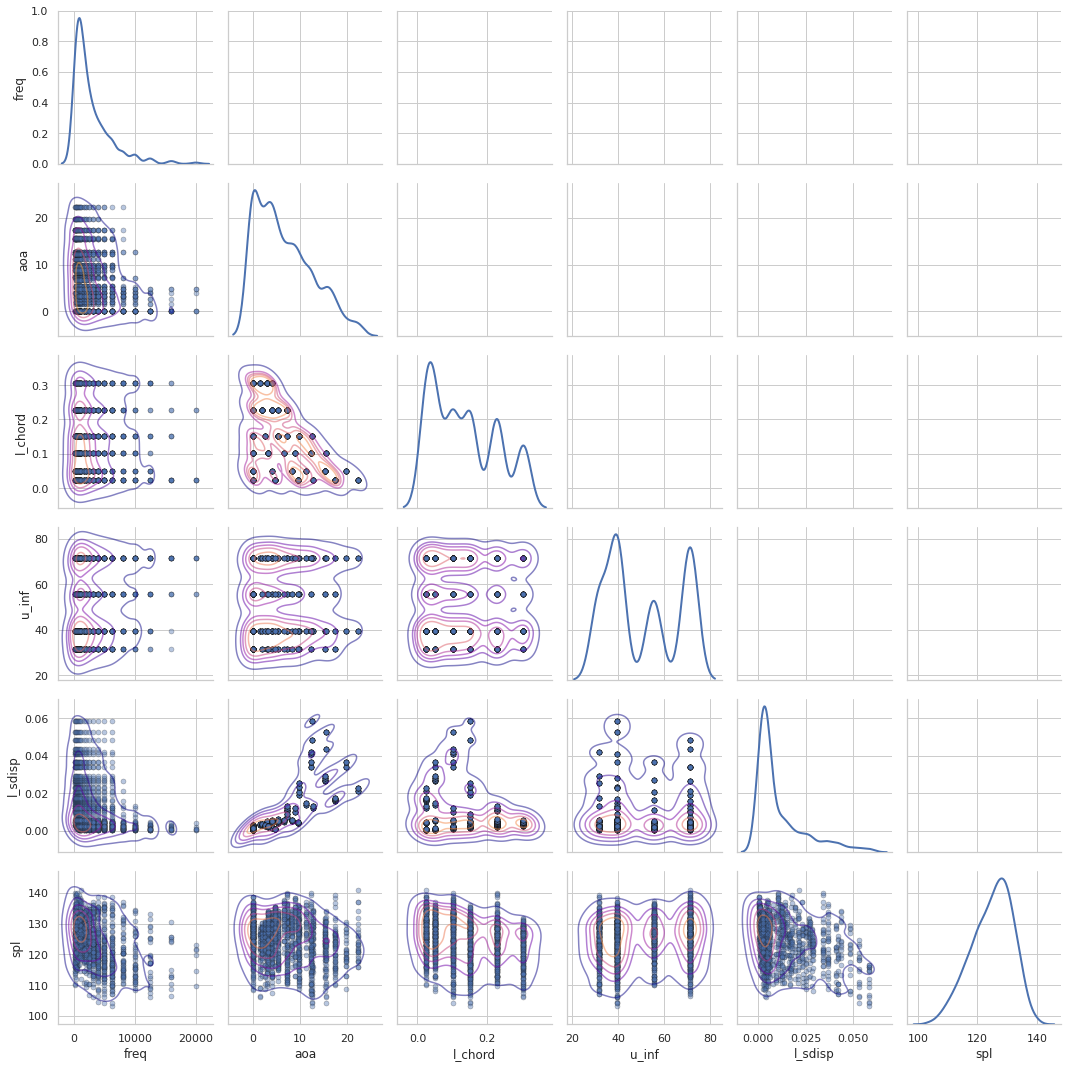

In [12]:
snsPairGrid(df)

`Univariate Histograms` <br>

- All features but `spl` contain lots of localised peaks in the histogram, `freq`,`aoa`,`l_chord`,`l_sdisp` are all heavily skewed in distribution. <br>
- As `u_inf`,`aoa` are our experiment conditions that are varied, it would be more useful to keep them as consistent as possible. 
- We have a lot of data for lower `aoa` as opposed to higher ones, less data for medium sized `l_chord` as well. Whilst `aoa` is probably pre-adjusted, `l_chord` & `u_inf` are probably not. 

`Bivariate Scatters` <br>

Lot's of interesting data relations here, focusing on `spl`: <br>

`freq|spl` is a useful relation, generally increasing and reducing, let's find out more in depth about it next. 120-130dB at a frequency of about 0-3kHz is quite populated. Looks like we have multiple peaks 140dB @ 3kHz & 140dB @ 7kHz (estimation), data above `freq>10kHz` is less populated <br>
`aoa|spl` is quite spread out throughout the entire data range. We need to subdivide the data a bit more, lots of spread of course suggests more simpler models will probably struggle here. <br>
`l_chord|spl` is quite random, no clear pattern emerges. Lower `l_chord` is associated with higher `SPL` reducing then going up and down again. Subdivision would prove more insightful.

**Other Comments** <br>
- We could say our data has a few feature with a bit of outliers, skewed features & feature with multiple peaks; suggesting nonlinearity. Especially for our target variable, `spl` we have a fair bit of scattering. A powerful model & data adjustment would prove quite valuable in this problem.
- Lets consider splitting the problem into a low & high 'aoa' prediction as angle is a significant factor in what sources of noise are created, higher angles tend to generate larger separation, we actually have `l_sdisp`, which is worth exploring a little.

## 3.2.<span style='color:#F1C40F'> EDA: Frequency Domain SPL Data Analysis</span>
- The most notable relation in noise analyses is the `freq` vs `spl` relation (frequency domain noise data)
- Looking at the entire data migh be a little overwhelming, let's check two `l_chord` cases only for now

In [13]:
def plotRel(ldf):
    sns.set(style='whitegrid')
    g = sns.relplot(x='freq',y='spl',col='u_inf',row='l_chord',data=ldf,
                kind='line',legend='full',hue='aoa',palette='jet_r',height=4)

In [14]:
''' Create Data Subsets for different airfoil sizes '''
sns.set(style='whitegrid')
pdlst_lchord = [] # list of pd subset data storing all unique 'l_chord'
lst_lchord_unique = df['l_chord'].unique().tolist();lst_lchord_unique.sort() # get unique 'l_chord'&sort()
for i in lst_lchord_unique:
    ldf = df[df['l_chord']==i].copy()
    pdlst_lchord.append(ldf)    # add all unique subsets to list

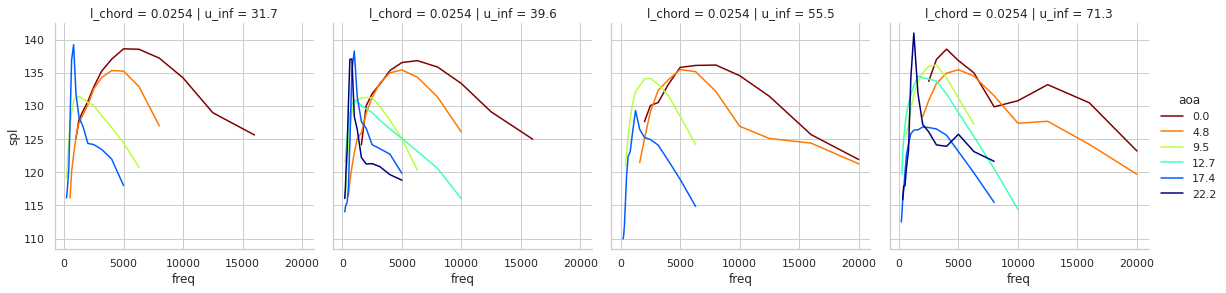

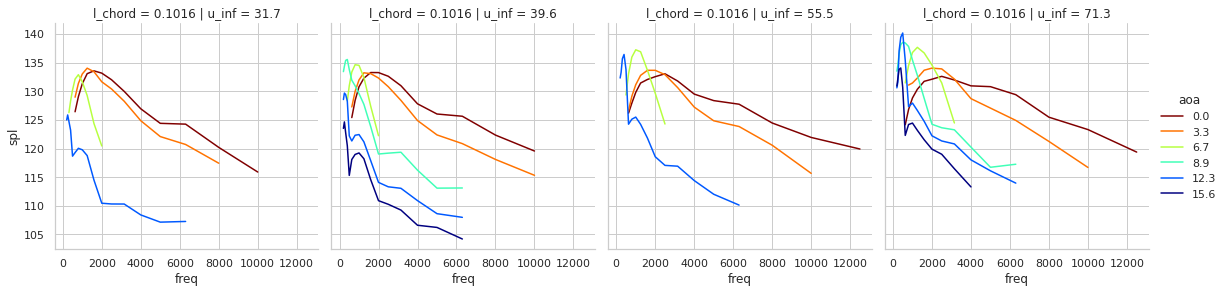

In [15]:
# lets plot two cases, they are ordered so smaller one on top.
plotRel(pdlst_lchord[0])
plotRel(pdlst_lchord[2])

- We can notice that the level of `spl` tends to go up, reach some maximum value and then go back down with increasing `freq` <br>
- We can also note that for a fixed `l_chord`, we have a relation `freq` vs `spl` for various `aoa` cases, which is represented by a line for each combination available to us, telling us the noise `spl` at a specific frequency `freq`, we can make some observations: 

`l_chord=0.0254`<br>
- `u_inf = 31.7` & `u_inf = 39.6` curves don't actually differ very much, suggesting the flow condition `u_inf` doesn't influence the flow very much in this range.
- for `aoa=0` & `aoa=4.8` we can note very high and wide `spl` curves, the `freq` range of generated noise is much higher than larger `aoa` cases, `u_inf=71.3` also generates an additional peak. It's likely this is associated with `TBL-TE` & `LBL-VS` noise sources.
- As `aoa` is increased, the noise `spl` output tends to start decreasing, and `freq` with it, at a certain `aoa`, a low `freq` peak starts to emerge. These cases are likely associated with `separated-stall` noise. For different `u_inf` the formation of a low `freq` is slightly different.

`l_chord=0.1016`<br>
- 75% of `spl` has slightly increased given a larger `l_chord`, the minumum has also reduced, and occurs at `u_inf=39.6` & `aoa=15.6`, on the graphs, we can see that a similar case in `l_chord=0.0254` & `aoa=17.4` generates higher spl output
- This reducing in SPL tendency with a reduction in `l_chord` we can visually see especially for `aoa=0`.
- We can note a similar tendency when increasing `aoa` as we noted earlier, the `freq` range reduces and starts generating a low `freq` peak. 
- We can also note an interesting twin peak at larger `aoa` values, they tend to be be within the 2kHz `freq` range. Smaller `l_chord` also had these peaks emerging, tending to be more flat, but for the larger `l_chord` it is much more visible with actual peaks, which may be an indicator of separated flow hitting the airfoil at some point or could be the noise associated with just separated flow; `Separation-Stall Noise` <br>
- We might note the slight plateau for the first two `u_inf` cases instead of going down, mainly for the lower angles, it seems like for the smaller `l_chord` it transitions into the clearly visible secondary peak.

Let's also not forget about Reynolds number, it's associated with also `density` & `viscosity`, but we don't have the data. An increase in Re should be associated with bottom&RHS. So perhaps `LBL-VS` is the associatiated noise source for the twin peak for `aoa=0,l_chord=0.0254,u_inf=71.3`

## 3.3. <span style='color:#F1C40F'> EDA: Boundary Layer Related Data (spl vs l_sdisp)</span>
- The feature `l_sdisp` is an indicator of how large the local boundary layer (BL) is at the sampled point on the upper surface.
- Let's again, look at some `l_chord` cases separately and see if we can spot anything.

In [16]:
sns.set(style='whitegrid')
lst = [0,2]
def relplot1(id):
    for i in id:
        g = sns.relplot(x='spl',y='l_sdisp',col='u_inf',row='l_chord',
                    hue='aoa',sizes='spl',palette='jet_r',
                    kind='scatter',legend='full',data=pdlst_lchord[i])
        g.fig.set_size_inches(13,3)
        leg = g._legend
        leg.set_bbox_to_anchor([1.06,1])  # coordinates of lower left of bounding box
        leg._loc = 1  # if required you can set the loc

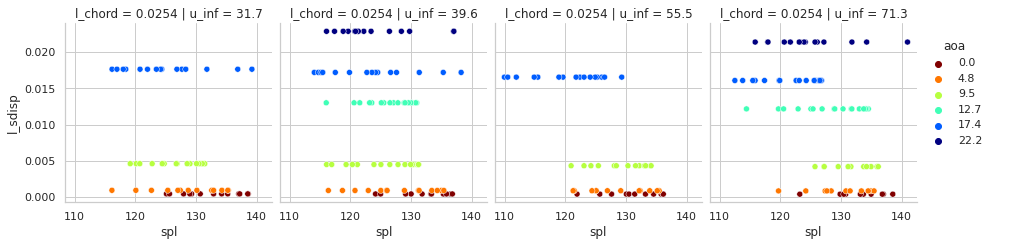

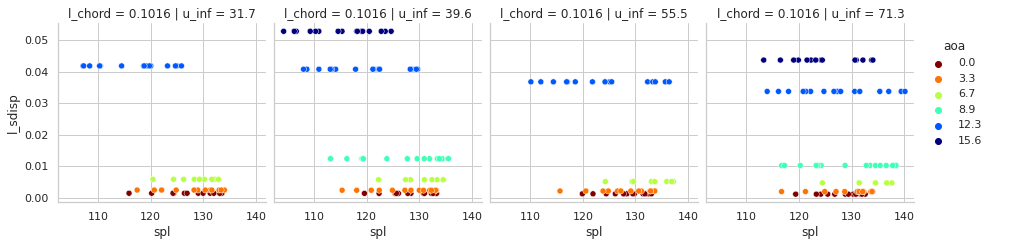

In [17]:
relplot1(lst)

- Larger `aoa` are quite consistently associated with larger `l_sdisp`, increasing quite rapidly. `spl` association to `l_sdisp` is rather tricky and as we can note is different depending on `l_chord` cases.
- `l_sdisp` does tend to reduce as `u_inf` is increased.
- `l_sdisp` increases depending on `l_chord` size and tends to have a rather wide `spl` output.
- `l_sdisp` variation doesn't seem to have any clearly distinctive relation to `spl`, it seems to be quite dependent the three variables `l_chord`,`aoa` & `u_inf`
- Larger `l_sdisp` are associated with larger separation, however the transition can be quite different for pretty much any angle in between the 0 and the maximum value. What it quite probable is the larger `aoa` cases being associated with the `separation stall noise`, which we noted have a distinctive low `freq` peak or twin peak.

## 3.4.<span style='color:#F1C40F'> EDA: Low Separation Cases (aoa=0)</span>


It was noted that `aoa=0` has the most complete combination of `l_chord` & `u_inf` data variation, let's try to explore this subset. Keeping in mind that the associated `TBL-TE` & `LVL-VS` noise sources should be relevant here as well.

### <span style='color:#5D6D7E'> EDA: l_chord variation in Frequency Spectrum (freq/spl)
let's take a look plotting the `freq` vs `spl` relation once again with the `u_inf` columns, but `aoa` changed to `l_chord`

In [18]:
df_a0 = df[df['aoa']==0.0].copy() # get all aoa=0 subset data

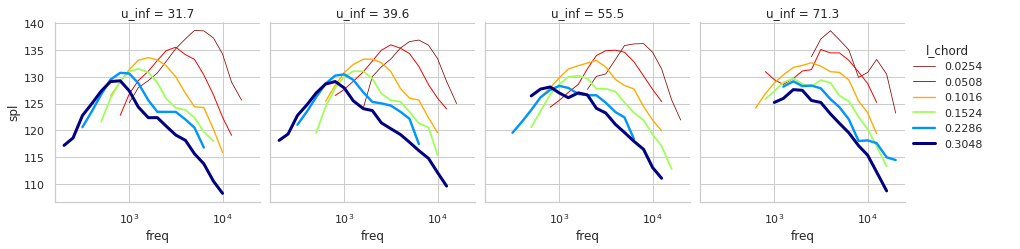

In [19]:
sns.set(style='whitegrid')
g = sns.relplot(x='freq',y='spl',col='u_inf',hue='l_chord',data=df_a0,palette='jet_r',
            kind='line',legend='full',size='l_chord');plt.xscale('log')
g.fig.set_size_inches(13,3)
leg = g._legend
leg.set_bbox_to_anchor([1.06,1])
leg._loc = 1 

- Lower <b>u_inf</b> tend to be somewhat more spread out, covering more lower `freq` values (wider frequency range)
- Lower <b>l_chord</b> tend to have <b>spl peaks in the higher freq region</b>, and visa versa. 
- Lower <b>l_chord</b> also tend to <b>generate higher maximum spl levels</b>, notable tendency of <b>spl</b>; reducing for larger `l_chord` cases.
- Lower `u_inf` case subgroups `u_inf=31.7,39.6` are more alike, especially with the notable low frequency peak for larger `l_chord`, a relatively constant pleuteu in the `spl=~125` region is visible, it could just be same noise source shared by larger `l_chord` cases.

### <span style='color:#5D6D7E'> EDA: Reynolds Number influence for low aoa cases</span>

- <b>Reynolds Number</b> is partly represented by <b>u_inf</b> & <b>l_chord</b>, other two (<b>density</b>&<b>viscosity</b>) we don't have. (Let's assume they don't change):
- <b>TBL-TE</b>,<b>LBL-VS</b> are two noise sources associated that we can associate with <b>Reynolds Number</b> variation. One said to occur at lower <b>Reynolds Number</b>, the other at higher <b>Reynolds Number</b>

In [20]:
df_a0['Reynolds'] = df_a0['u_inf']*df_a0['l_chord'] 

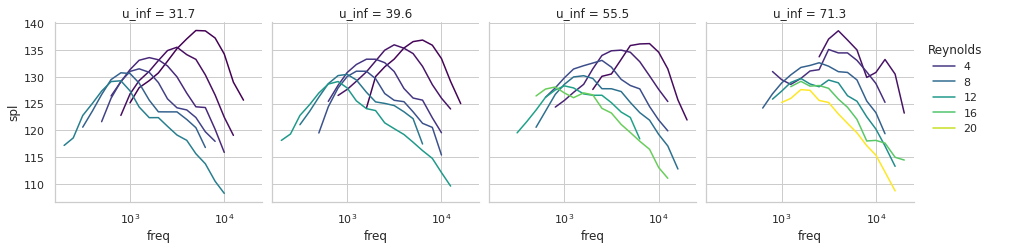

In [21]:
sns.set(style='whitegrid')
g = sns.relplot(x='freq',y='spl',col='u_inf',hue='Reynolds',
            data=df_a0,kind='line',palette='viridis');plt.xscale('log')
g.fig.set_size_inches(13,3)

leg = g._legend
leg.set_bbox_to_anchor([1.06,1])  # coordinates of lower left of bounding box
leg._loc = 1
for t in leg.texts:
    t.set_text(t.get_text()[:4])

- We can note the twin peak is associated with the lower `Reynolds` number, which is much higher `spl` than the lower `Reynolds` peak. 
- Lower `Reynolds` number cases are also associated with higher `spl` noise, in general. <br> 
- It's not quite straightforward to differentiate the two possible sources, low & high `Reynolds` numbers are also quite subjective. 
- What we can note that the higher `Reynolds` have two distrinctive peaks, which tend to tranform into a levelled out `plateau` at higher `freq` as the `Reynolds` number is reduced. 
- If there is a clear location a model might stumble on it would be the twin peak at `u_inf=71.3` which is quite probably associated with the low `Reynolds` associated `LBL-VS` noise.

## 3.5. <span style='color:#F1C40F'>EDA: Higher Flow Separation Cases (aoa>0)</span>

- Whilst `aoa=0` can still have flow separation, most notably at very high `u_inf`, the flow separation is very minor 
- Larger flow separation is associated with higher <b>aoa</b> values.
- Let's group all the higher <b>aoa</b> case we have & see if we can note anything associated to `spl` as `aoa` is increased.

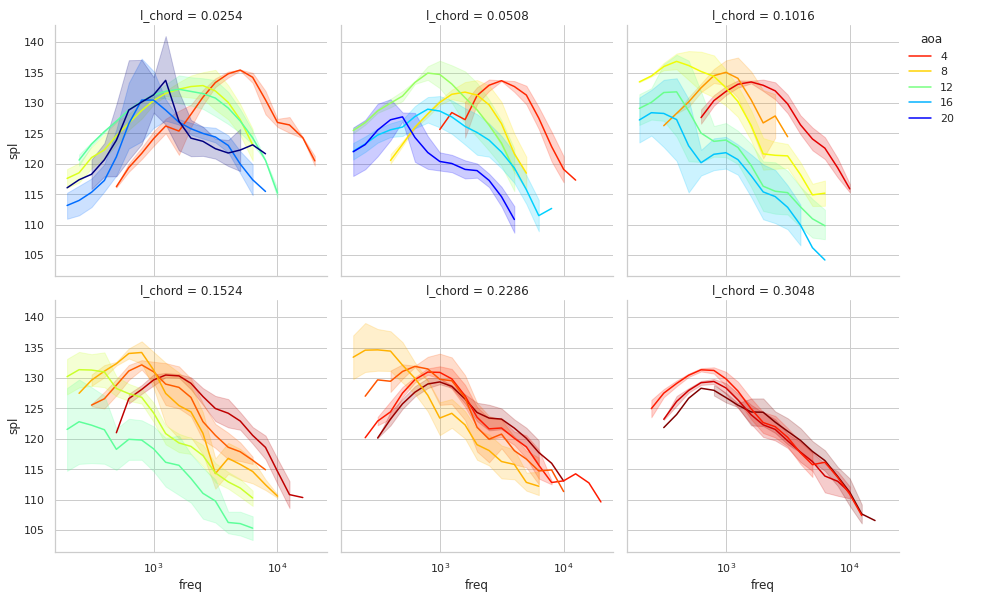

In [22]:
sns.set(style='whitegrid')
df_aplus = df[df['aoa']>0.0].copy()
g = sns.relplot(x='freq',y='spl',col='l_chord',kind='line',hue='aoa',col_wrap=3,
            data=df_aplus,palette='jet_r');plt.minorticks_on();plt.xscale('log')
g.fig.set_size_inches(13,8)
leg = g._legend
leg.set_bbox_to_anchor([1.03,1]) 
leg._loc = 1

- An increase in `aoa` tends to move the spectrum diagonally towards lower `freq` and `spl` simultaneously
- The higher the `aoa` becomes, the more notable the low `freq` peaks become, quite often generating a higher local `spl` maximum at a very narrow `freq` range.
- Medium sized `l_chord` & `aoa` tend to be associated with more freqent localised `spl` variation in the mid frequency range.

# 4. Model Generation

- Let's create a separate model for low flow separation cases `aoa=0`
- Create a model higher angle cases `aoa>0` (Associated with larger flow separation)
- Finish of with a hybrid of the two.  (A generalised model)

**Physics Prediction**

- It must be noted that in depth cross validation and the concept of 'overfitting/underfitting' are aspects that one should pay close attention to in a general Machine Learning project, as we generally are concerned in integrating our model on unseen data
- We are assuming that physics of flow phenomenon would change radically for the model to become less valid given new data.

## 4.1. <span style='color:#F1C40F'> Gaussian Process (GP) Regressor, GPR()</span>

- GP has the ability to accurately adapt to data it is provided in a high dimensional space. Which can be its strength or weakness, depending on the problem. 
- The model is actually quite versatile, it has the ability to both overpredict & underpredict. How the model behaves is related to its hyperparameters.
- Overfitting is likely if the model is used in its automated form, often implemented by default. It's usually a good idea to pay attention to these hyperparameters in a more manual search format.
- Each hyperparameter has it's own role in how it changes the model, with its core being the covariance matrix, which defines all of the instance relation weights in a neat matrix format. Multiple covariance matrices have to be constructed to make a prediction, including matrix inversions, yet GP is the cheaper variant of all models associated with it.

GP has several hyperparameters which must be set to train the model, three are set `theta`,`sigma`,`sigma_n`
***
- Two `hyperaparameters` are associated with the `covariance function` (`kernel` if you prefer); `theta` & `sigma`, this function is used to define all weights in the `covariance matrix`. These functions are used in both `variance` & `covariance` parts of the `covariance matrix`. These functions can be set in whatever combination suits your problem.
- The last, `sigma_n` is a hyperparameter associated with the diagonal term in the `covariance matrix`, influencing the `variance` component only. Implying how relevant the training nodes are; (noise/noiseless) assumption.
- A brief Class explanation is aded below:

**Model Instantiation Options**
***
In a OOP formulation, classes need to be initialised. Having done that, activates `__init__` content: <br>

**Hyperparameters** <br>
- `self.theta` is the `covariance function` associated `hyperparameter`, similar for the other two. 
- `__init__` sets the parameters to a default value (`theta=10`,`sigma=10`,`sigma_n=1`) if not set; GPR(). 
- You can set them manually GPR(theta=1,sigma=1,sigma_n=0.01,opt=False), but `opt=False` must be present to prevent `hyperparameters` to be overwritten. <br>

**Other options**
- self.opt is the previously mentioned activator for `objective function` optimisation.
- GPR.kernel is a common class variable of GPR, defining the type of `covariance function` used. The same function is used for all weight relations of the `covariance matrix`.

**Training the GPR() model**, `.fit(X,y)`
***
- Setting `hyperparameters` & calculating the training `covariance matrix`. 
- Hyperparameters can be both set in the manner outlined above, or tuned based on a specific `objective function`. 
- Various `objective functions` exist, the full `likelihood` & simplified variant is included, `MSE` is another alternative.
- Scipy's `optimize.minimize` class is used together with the `L-BFGS-B` approach to find the minimum, `Nelder-Mead` is also nice. It's worth trying different approaches as minimisation approaches vary.

**Making a prediction using the GPR() model**, `.predict(X)`
***
- The `Covariance Matrix` for Training & Test Feature Matrices needs to be calculated.
- Commonly referred to as the `posterior mean` is the main model prediction output.

In [23]:
from sklearn.base import BaseEstimator,RegressorMixin
from numpy.linalg import cholesky, det, lstsq, inv, eigvalsh, pinv
from scipy.optimize import minimize
pi = 4.0*np.arctan(1.0)

# Usage similar to any sklearn model
class GPR(BaseEstimator,RegressorMixin):

    ''' Class Instantiation Related Variables '''
    # With just the one class specific GPC.kernel
    def __init__(self,kernel='rbf',theta=10.0,sigma=10.0,sigma_n=0.01,opt=True):
        self.theta = theta            # Hyperparameter associated with covariance function
        self.sigma = sigma            #                       ''
        self.sigma_n = sigma_n        # Hyperparameter associated with cov.mat's diagonal component
        self.opt = opt                # Update hyperparameters with objective function optimisation
        GPR.kernel = kernel           # Selection of Covariance Function, class specific instantiation

    ''' local covariance functions '''
    # Covariance Functions represent a form of weight adjustor in the matrix W/K
    # for each of the combinations present in the feature matrix
    @staticmethod
    def covfn(X0,X1,theta=1.0,sigma=1.0):

        ''' Radial Basis Covariance Function '''
        if(GPR.kernel == 'rbf'):
            r = np.sum(X0**2,1).reshape(-1,1) + np.sum(X1**2,1) - 2 * np.dot(X0,X1.T)
            return sigma**2 * np.exp(-0.5/theta**2*r)

        ''' Matern Covariance Class of Funtions '''
        if(GPR.kernel == 'matern'):
            lid=2
            r = np.sum(X0**2,1)[:,None] + np.sum(X1**2,1) - 2 * np.dot(X0,X1.T)
            if(lid==1):
                return sigma**2 * np.exp(-r/theta)
            elif(lid==2):
                ratio = r/theta
                v1 = (1.0+np.sqrt(3)*ratio)
                v2 = np.exp(-np.sqrt(3)*ratio)
                return sigma**2*v1*v2
            elif(lid==3):
                ratio = r/theta
                v1 = (1.0+np.sqrt(5)*ratio+(5.0/3.0)*ratio**2)
                v2 = np.exp(-np.sqrt(5)*ratio)
                return sigma**2*v1*v2
        else:
            print('Covariance Function not defined')
    
    ''' Train the GPR Model'''
    def fit(self,X,y):
        
        # Two Parts Associated with base GP Model:
        # - Hyperaparemeter; theta, sigma, sigma_n selection
        # - Definition of Training Covariance Matrix
        # Both are recalled in Posterior Prediction, predict()
        
        ''' Working w/ numpy matrices'''
        if(type(X) is np.ndarray):
            self.X = X;self.y = y
        else:
            self.X = X.values; self.y = y.values
        self.ntot,ndim = self.X.shape

        ''' Optimisation Objective Function '''
        # Optimisation of hyperparameters via the objective funciton
        def llhobj(X,y,noise):
            
            # Simplified Variant
            def llh_dir(hypers):
                K = self.covfn(X,X,theta=hypers[0],sigma=hypers[1]) + noise**2 * np.eye(self.ntot)
                return 0.5 * np.log(det(K)) + \
                    0.5 * y.T.dot(inv(K).dot(y)).ravel()[0] + 0.5 * len(X) * np.log(2*pi)

            # Full Likelihood Equation
            def nll_full(hypers):
                K = self.covfn(X,X,theta=hypers[0],sigma=hypers[1]) + noise**2 * np.eye(self.ntot)
                L = cholesky(K)
                return np.sum(np.log(np.diagonal(L))) + \
                    0.5 * y.T.dot(lstsq(L.T, lstsq(L,y)[0])[0]) + \
                    0.5 * len(X) * np.log(2*pi)

            return llh_dir # return one of the two, simplified variant doesn't always work well

        ''' Update hyperparameters based on set objective function '''
        if(self.opt==True):
            # define the objective funciton
            objfn = llhobj(self.X,self.y,self.sigma_n)
            # search for the optimal hyperparameters based on given relation
            res = minimize(objfn,[1,1],bounds=((1e-5,None),(1e-5, None)),method='L-BFGS-B')
            self.theta,self.sigma = res.x # update the hyperparameters to 

        ''' Get Training Covariance Matrix, K^-1 '''
        Kmat = self.covfn(self.X,self.X,self.theta,self.sigma) \
                 + self.sigma_n**2 * np.eye(self.ntot) # Covariance Matrix (Train/Train)
        self.IKmat = pinv(Kmat) # Pseudo Matrix Inversion (More Stable)
        return self  # return class & use w/ predict()

    ''' Posterior Prediction;  '''
    # Make a prediction based on what the model has learned 
    def predict(self,Xm):
        
        ''' Working w/ numpy matrices'''
        if(type(Xm) is np.ndarray):
            self.Xm = Xm
        else:
            self.Xm = Xm.values
        
        # Covariance Matrices x2 required; (Train/Train,Train/Test)
        mtot = Xm.shape[0]  # Number of Test Matrix Instances
        K_s = self.covfn(self.X,Xm.values,self.theta,self.sigma)  # Covariance Matrix (Train/Test)               
        self.mu_s = K_s.T.dot(self.IKmat).dot(self.y)      # Posterior Mean Prediction
        return self.mu_s # return posterior mean

## 4.3. <span style='color:#F1C40F'> Low Flow Separation Model</span>
- We can assess the accuracy of the model by plotting the model prediction values against the `spl` values
- Smaller error is associated with more linear lines
- let's take a look at what the model predicts as well:

In [24]:
def modelEval(ldf,feature='spl'):

    # Given a dataframe, split feature/target variable
    dfX = ldf.copy()
    t = ldf[feature].copy()
    del dfX[feature]
    
    model = GPR(opt=True)    # instantiate GPR model
    model.fit(dfX,t)        # fit model to desired feature matrix
    
    return model,dfX,t      # return model, feature matrix and target variable

In [25]:
del df_a0['Reynolds']            # lets remove this feature
df_a0['aoa'] = 0.0               # we need to readd the feature
tdf_a0 = df_a0['freq'].copy()
model_a0,X0,y0 = modelEval(df_a0)

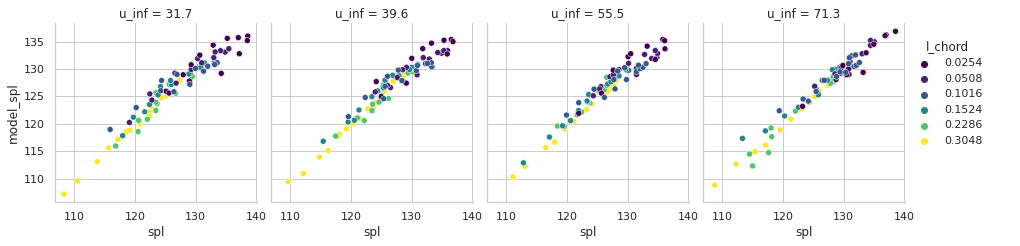

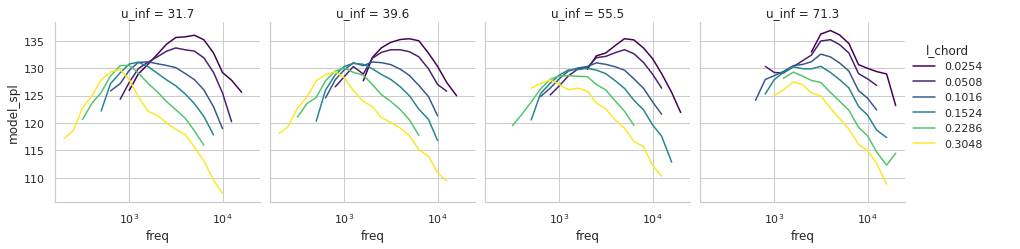

In [26]:
df_a0['model_spl'] = model_a0.predict(X0)
# plot experiment_spl vs model_spl
g = sns.relplot(x='spl',y='model_spl',col='u_inf',hue='l_chord',data=df_a0,palette='viridis',
            kind='scatter',legend='full');plt.minorticks_on()
g.fig.set_size_inches(13,3)
leg = g._legend
leg.set_bbox_to_anchor([1.06,1])  # coordinates of lower left of bounding box
leg._loc = 1  # if required you can set the loc

# plot model spl vs freq prediction
g = sns.relplot(x='freq',y='model_spl',col='u_inf',hue='l_chord',data=df_a0,palette='viridis',
            kind='line',legend='full');plt.minorticks_on();plt.xscale('log')
g.fig.set_size_inches(13,3)
leg = g._legend
leg.set_bbox_to_anchor([1.06,1])  # coordinates of lower left of bounding box
leg._loc = 1  # if required you can set the loc

We can see that the `aoa=0` model is not quite as accurate as hoped, missing some details in the spectrum here and there, especially for lower `l_chord` cases. It could simply be due to insufficient data, or may not be, we can confirm this by simply reintroducing another feature we had before; `Reynolds` number.

In [27]:
del df_a0['model_spl']
df_a0['Reynolds'] = df_a0['u_inf']*df_a0['l_chord']

model_a0B,X0B,y0B = modelEval(df_a0)
df_a0['model_spl'] = model_a0B.predict(X0B)

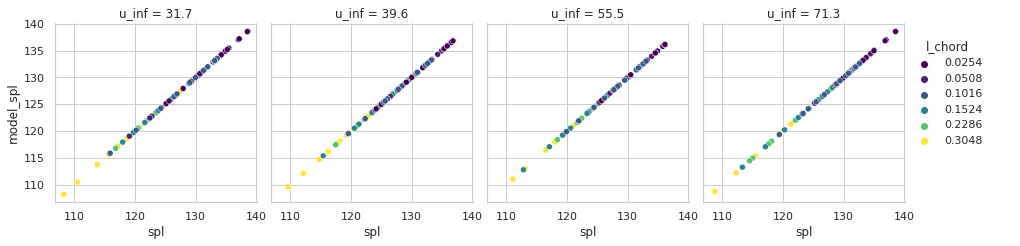

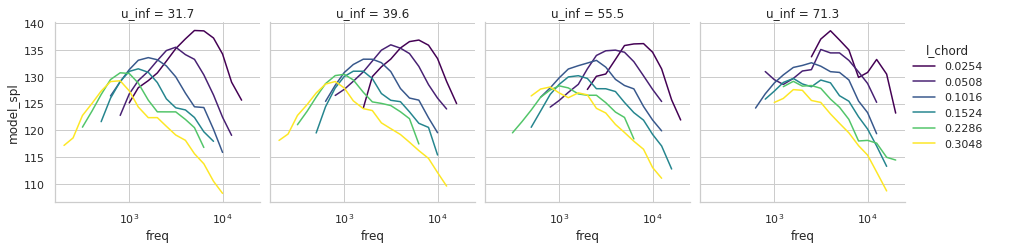

In [28]:
# plot experiment_spl vs model_spl
f = sns.relplot(x='spl',y='model_spl',col='u_inf',hue='l_chord',data=df_a0,palette='viridis',
            kind='scatter',legend='full');plt.minorticks_on()
f.fig.set_size_inches(13,3)
leg = f._legend
leg.set_bbox_to_anchor([1.06,1])  # coordinates of lower left of bounding box
leg._loc = 1  # if required you can set the loc

# plot model spl vs freq prediction
g = sns.relplot(x='freq',y='model_spl',col='u_inf',hue='l_chord',data=df_a0,palette='viridis',
            kind='line',legend='full');plt.minorticks_on();plt.xscale('log')
g.fig.set_size_inches(13,3)
leg = g._legend
leg.set_bbox_to_anchor([1.06,1])  # coordinates of lower left of bounding box
leg._loc = 1  # if required you can set the loc

Looks like adding the `Reynolds` feature improved the misspredictions, especially the lower `l_chord` cases, looks quite neatly aligned now.

## 4.4. <span style='color:#F1C40F'> High Flow Separation Model</span>
Taking a look at the relation model prediction vs `spl` again:

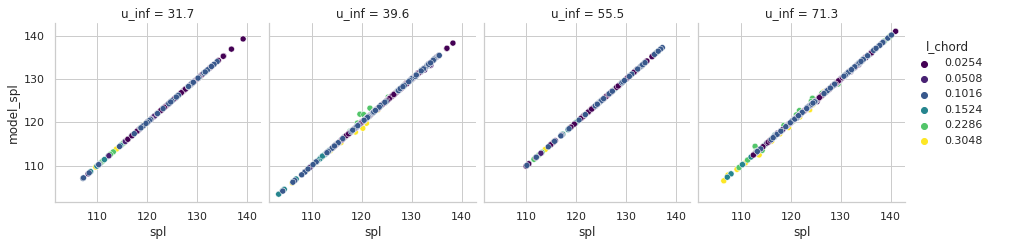

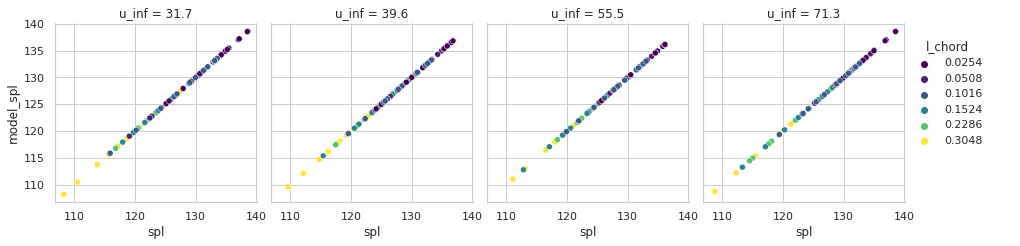

In [29]:
model_aplus,X1,y1 = modelEval(df_aplus)
df_aplus['model_spl'] = model_aplus.predict(X1)
f = sns.relplot(x='spl',y='model_spl',col='u_inf',hue='l_chord',data=df_aplus,palette='viridis',
            kind='scatter',legend='full');plt.minorticks_on()
f.fig.set_size_inches(13,3)
leg = f._legend
leg.set_bbox_to_anchor([1.06,1])  # coordinates of lower left of bounding box
leg._loc = 1  # if required you can set the loc

del df_aplus['model_spl']
df_aplus['Reynolds'] = df_aplus['u_inf']*df_aplus['l_chord']

model_aplusB,X1B,y1B = modelEval(df_aplus)
df_aplus['model_spl'] = model_aplusB.predict(X1B)

g = sns.relplot(x='spl',y='model_spl',col='u_inf',hue='l_chord',data=df_a0,palette='viridis',
            kind='scatter',legend='full');plt.minorticks_on()
g.fig.set_size_inches(13,3)
leg = g._legend
leg.set_bbox_to_anchor([1.06,1])  # coordinates of lower left of bounding box
leg._loc = 1  # if required you can set the loc

- High flow separation cases are predicted much better than the lower flow separation case when using the same hyperparameter optimisation approach. 
- Some minor variation for higher `l_chord` cases can be noted. Let's see if the addition of `Reynolds` number can help increase the accuracy of the higher `l_chord` cases.
- `Reynolds` feature also has a positive effect on model accuracy for the higher `aoa` model.

## 4.5. <span style='color:#F1C40F'> Overall Model </span>
The Overall model should have similar mispredictions to both previous models, let's take a look:

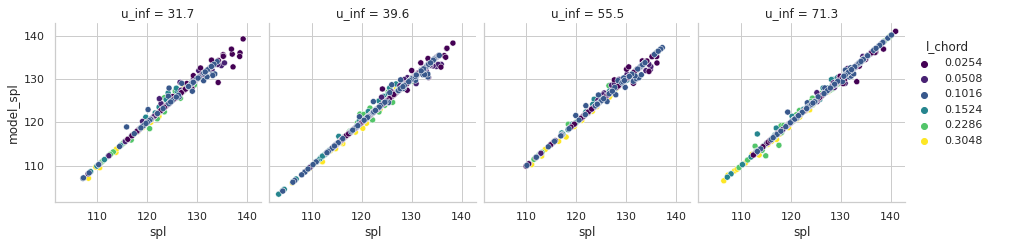

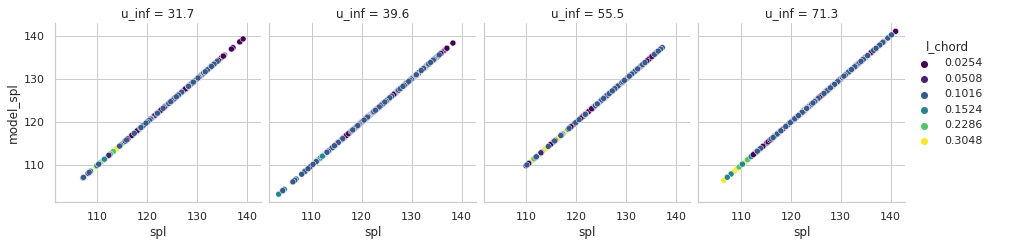

In [30]:
model_all,X2,y2 = modelEval(df)
df['model_spl'] = model_all.predict(X2)
f = sns.relplot(x='spl',y='model_spl',col='u_inf',hue='l_chord',data=df,palette='viridis',
            kind='scatter',legend='full')
f.fig.set_size_inches(13,3)
leg = f._legend
leg.set_bbox_to_anchor([1.06,1])  # coordinates of lower left of bounding box
leg._loc = 1  # if required you can set the loc

del df['model_spl']
df['Reynolds'] = df['u_inf']*df['l_chord']

model_aplusB,X1B,y1B = modelEval(df)
df['model_spl'] = model_aplusB.predict(X1B)
g = sns.relplot(x='spl',y='model_spl',col='u_inf',hue='l_chord',data=df,palette='viridis',
            kind='scatter',legend='full');plt.minorticks_on()
g.fig.set_size_inches(13,3)
leg = g._legend
leg.set_bbox_to_anchor([1.06,1])  # coordinates of lower left of bounding box
leg._loc = 1  # if required you can set the loc

- Looks like we have very similar misspredictions for the overall model (both lower and higher `l_chord` cases.
- After add the additional feature, by the looks of it, we have made quite an accurate model for the prediction of `spl`.
- The Gaussian based model knows can be a little too accurate for many problems, in that case you can simply adjust the hyperparameters, especially the matrix diagonal term. In this problem, we assumed that the noise hyperparameter, `sigma_n` is equal to 0.01 here.

# 5. Conclusion

In this problem, we aimed to create a model that would predict the target variable `spl`, given a set of features. A brief EDA was conducted, some interesting relations were noted. Each individual spectrum has its own unique relation to `spl`, it's not exactly possible to pinpoint exact spectrum noise sources, given we don't have anything visual to go by. More notably was the `Reynolds` number relation that was noted in the experiment noise sources. This feature actually helped improve the model which was quite nice, in the end the `GP` model was able to quite precisely predict the `spl`.

Thank you for reading!

**References** <br>
T.F. Brooks, D.S. Pope, and A.M. Marcolini. Airfoil self-noise and prediction. Technical report, NASA RP-1218, July 1989. 

If you find anything useful, please consider upvoting/commenting, it would be really appreciated, thank you.